# Проект: Определение  рыночной стоимости автомобилей

## Описание проекта:
Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. 
Постройте модель, которая умеет её определять. В вашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.

## Задачи:
1) Загрузить и подготовить данные.
2) Обучить разные модели. Для каждой попробовать различные гиперпараметеры.
3) Проанализировать скорость работы и качество моделей.

## Описание данных

Признаки
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак
- Price — цена (евро)

---

# Импорты и подготовка данных

In [1]:
!pip install scikit-learn==1.1.3 -q

In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor

In [3]:
try:
    df = pd.read_csv("/datasets/autos.csv")
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [4]:
df.head(15)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [7]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [8]:
df.columns = df.columns.str.lower()

In [9]:
df = df.rename(columns={'vehicletype':'vehicle_type', 
                        'registrationyear':'registration_year',
                        'fueltype':'fuel_type', 
                        'notrepaired':'not_repaired',})

In [10]:
df = df.drop(['numberofpictures', 'postalcode', 'datecreated', 'datecrawled', 'lastseen', 'registrationmonth'], axis=1)

In [11]:
rows_with_missing_values = df[df.isnull().any(axis=1)]
rows_with_missing_values

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,NaN
9,999,small,1998,manual,101,golf,150000,NaN,volkswagen,NaN
...,...,...,...,...,...,...,...,...,...,...
354357,1690,wagon,2004,manual,55,fabia,150000,petrol,skoda,NaN
354361,5250,NaN,2016,auto,150,159,150000,NaN,alfa_romeo,no
354364,0,NaN,2005,manual,0,colt,150000,petrol,mitsubishi,yes
354365,2200,NaN,2005,NaN,0,NaN,20000,NaN,sonstige_autos,NaN


В столбеце registration_year значения не могут быть больше 2016 и меньше 1930.

In [12]:
df = df.loc[(df['registration_year'] <= 2016) & (df['registration_year'] >= 1930)]

Теперь перейдем к столбцу с мощностью. Посмотрим на распределение мощности.

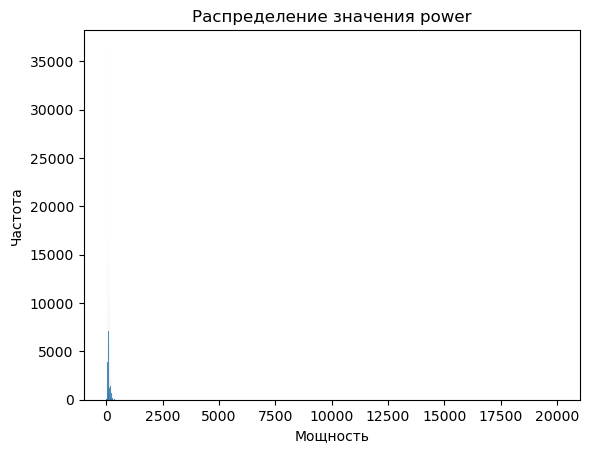

In [13]:
sns.histplot(df['power'])
plt.title('Распределение значения power')
plt.xlabel('Мощность')
plt.ylabel('Частота')
plt.show()

Похоже в данных есть выбросы, обрежем график по оси x.

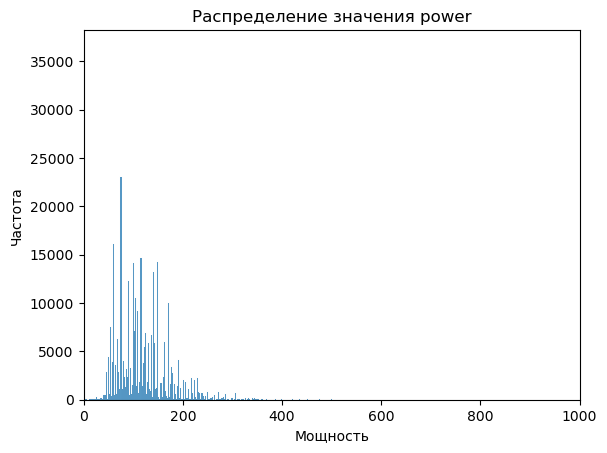

In [14]:
sns.histplot(df['power'])

plt.xlim(0, 1000) 

plt.title('Распределение значения power')
plt.xlabel('Мощность')
plt.ylabel('Частота')

plt.show()

Узнаем в каком промежутке находиться 99% значений столбца power.

In [15]:
percentile_99 = np.percentile(df['power'], 99)

print("99-й процентиль:", percentile_99)

99-й процентиль: 300.0


Почти все значения столбца находяться до 300, следовательно мы можем исключить все значения выше данного порога. А все пропуски заполним значениями медианы.

In [16]:
df = df.loc[df['power'] <= 300]

In [17]:
df['power'] = df['power'].replace(0, df['power'].median())

Перейдем к столбцу с ценой, также посмотрим на распределение значений

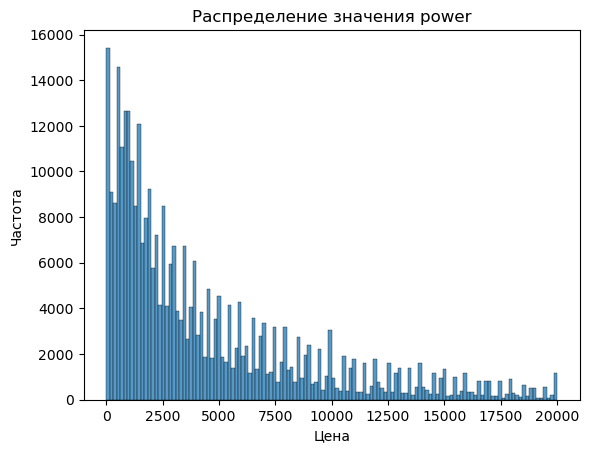

In [18]:
sns.histplot(df['price'])
plt.title('Распределение значения power')
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.show()

У нас очень много нулевых значений, однако вряд ли объявления с нулевой ценой - реальны. Цена не может быть нулевой, к тому же это целевой признак, удалим такие значения. 

In [19]:
df = df[df['price'] != 0]

В столбцах 'vehicle_type', 'fuel_type', 'gearbox', 'repaired' и 'model' мы не можем логически заполнить пропуски, следовательно заполним значение unknown.

In [20]:
columns_to_fill = ['vehicle_type', 'fuel_type', 'gearbox', 'repaired', 'model']
df[columns_to_fill] = df[columns_to_fill].fillna('unknown')

In [21]:
df.duplicated().sum()

42152

Удалим дубликаты

In [22]:
df.drop_duplicates(inplace=True)

In [23]:
df.duplicated().sum()

0

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284259 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              284259 non-null  int64 
 1   vehicle_type       284259 non-null  object
 2   registration_year  284259 non-null  int64 
 3   gearbox            284259 non-null  object
 4   power              284259 non-null  int64 
 5   model              284259 non-null  object
 6   kilometer          284259 non-null  int64 
 7   fuel_type          284259 non-null  object
 8   brand              284259 non-null  object
 9   repaired           284259 non-null  object
dtypes: int64(4), object(6)
memory usage: 23.9+ MB


### Промежуточный итог:
1. **Импортировали необходимые библиотеки**
2. **Посмотрели на данные и обнаружили в них недочеты которые необходимо исправить**
3. **Обработали датафрейм:**
- **Исправили названия столбцов** 
- **Убрали лишние столбцы, так как они не несут в себе ключевую информацию необходимую для построения качественных моделей**
- **Заполнили пропущенные значения на 'unknown', так как невозможно уточнить их**
- **Отфильтровали строки**
- **Удалили дубликаты**

### Кодируем и разделяем выборки  

In [25]:
category = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
num_columns = ['registration_year', 'power', 'kilometer']

In [26]:
target = df['price']
features = df.drop('price', axis=1)
features_train, features_test, target_train, target_test = train_test_split(features, \
                                                target, test_size=0.2, random_state=12345)

In [27]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
features_train_en = encoder.fit_transform(features_train[category])
features_test_en = encoder.transform(features_test[category])

In [28]:
encoder_col_names = encoder.get_feature_names_out()

In [29]:
scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(features_train[num_columns])
features_test_scaled = scaler.transform(features_test[num_columns])

In [30]:
features_train_en = pd.DataFrame(features_train_en, columns=encoder_col_names)
features_test_en = pd.DataFrame(features_test_en, columns=encoder_col_names)

In [31]:
features_train_scaled = pd.DataFrame(features_train_scaled, columns=num_columns)
features_test_scaled = pd.DataFrame(features_test_scaled, columns=num_columns)

In [32]:
features_train = pd.concat([features_train_en, features_train_scaled], axis=1)
features_test = pd.concat([features_test_en, features_test_scaled], axis=1)

In [33]:
target_lgb = df['price']
features_lgb = df.drop('price', axis=1)

for c in features_lgb.columns:
  col_type = features_lgb[c].dtype
  if col_type == 'object':
    features_lgb[c] = features_lgb[c].astype('category')

features_train_lgb, features_test_lgb, target_train_lgb, target_test_lgb = train_test_split(features_lgb, \
                                                            target_lgb, test_size=0.2, random_state=12345)


In [34]:
target_train_lgb = target_train_lgb.astype(int)

In [35]:
scaler = StandardScaler()
features_train_lgb = scaler.fit_transform(features_train_lgb[num_columns])
features_test_lgb = scaler.transform(features_test_lgb[num_columns])

## Вывод: 
- Признаки были преобразованы с использованием кодирования ordinal. Далее данные были разделены на тестовую и обучающую выборки. После этого признаки были масштабированы, приведены к стандартному нормальному распределению, с использованием метода StandardScaler.
- Теперь можно приступать к обучению моделей.

# Обучение моделей

In [36]:
model_dt= DecisionTreeRegressor(random_state=12345)
param_grid = {
    "max_depth" : range(1,10),
    "min_samples_leaf" : range(1,11)
}

rs_search = RandomizedSearchCV(model_dt, param_distributions=param_grid, scoring='neg_root_mean_squared_error', cv=5)
start_time = time.time()
dt_model = rs_search.fit(features_train, target_train)
end_time = time.time()

execution_time = round(end_time - start_time, 1)

best_model_tree = dt_model.best_estimator_

start = time.time()

best_model_tree.fit(features_train, target_train)

end = time.time()

learning_time = round(end-start, 2)

start = time.time()

best_model_tree.predict(features_train)

end = time.time()

prediction_time = round(end-start, 2)

print(f'Лучшая RMSE дерева решений на кросс-валидации : {-rs_search.best_score_} при параметрах {rs_search.best_params_}')
print(f'\nВремя обучения: {learning_time} секунды')
print(f'\nВремя предсказания: {prediction_time} секунды')

Лучшая RMSE дерева решений на кросс-валидации : 2089.9137693950543 при параметрах {'min_samples_leaf': 2, 'max_depth': 9}

Время обучения: 0.27 секунды

Время предсказания: 0.01 секунды


### CatBoostRegressor

In [37]:
%%time

catboost = CatBoostRegressor(loss_function='RMSE', random_state=12345, verbose=False)

param_grid = {
    'depth': [1, 10],
    'learning_rate': np.arange(0.1, 1, 0.2)
}

CPU times: user 40 µs, sys: 180 µs, total: 220 µs
Wall time: 1.44 ms


In [38]:
rs_search_cat = RandomizedSearchCV(catboost, param_distributions=param_grid, scoring='neg_root_mean_squared_error', cv=3)

rs_search_cat.fit(features_train, target_train)

RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostRegressor object at 0x282ad3f10>,
                   param_distributions={'depth': [1, 10],
                                        'learning_rate': array([0.1, 0.3, 0.5, 0.7, 0.9])},
                   scoring='neg_root_mean_squared_error')

In [39]:
best_model_cat = rs_search_cat.best_estimator_

start = time.time()

best_model_cat.fit(features_train, target_train)

end = time.time()

learning_time = round(end-start, 2)

start = time.time()

best_model_cat.predict(features_train)

end = time.time()

prediction_time = round(end-start, 2)

In [40]:
print(f'Лучшая RMSE: {-rs_search_cat.best_score_} при параметрах {rs_search_cat.best_params_}')
print(f'\nВремя обучения: {learning_time} секунд')
print(f'\nВремя предсказания: {prediction_time} секунд')

Лучшая RMSE: 1621.3202955256063 при параметрах {'learning_rate': 0.1, 'depth': 10}

Время обучения: 17.95 секунд

Время предсказания: 0.14 секунд


### LightGBM

In [43]:
%%time
estim_new = lgb.LGBMRegressor(random_state=12345, verbosity=-1)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.05, 0.1, 0.2]
}


gbm = RandomizedSearchCV(estim_new, param_distributions=param_grid, cv=5, scoring='neg_root_mean_squared_error')

gbm.fit(features_train_lgb, target_train_lgb)

CPU times: user 3min 29s, sys: 51.8 s, total: 4min 21s
Wall time: 38.7 s


RandomizedSearchCV(cv=5,
                   estimator=LGBMRegressor(random_state=12345, verbosity=-1),
                   param_distributions={'learning_rate': [0.05, 0.1, 0.2],
                                        'max_depth': [5, 10, 15],
                                        'n_estimators': [100, 200, 300]},
                   scoring='neg_root_mean_squared_error')

In [44]:
best_model_gmb = gbm.best_estimator_

start = time.time()

best_model_gmb.fit(features_train, target_train)

end = time.time()

learning_time = round(end-start, 2)

start = time.time()

best_model_gmb.predict(features_train)

end = time.time()

prediction_time = round(end-start, 2)

print(f'Лучшая RMSE: {-gbm.best_score_} при параметрах {gbm.best_params_}')
print(f'\nВремя обучения: {learning_time} секунд')
print(f'\nВремя предсказания: {prediction_time} секунд')

Лучшая RMSE: 2122.414125473505 при параметрах {'n_estimators': 300, 'max_depth': 15, 'learning_rate': 0.2}

Время обучения: 1.4 секунд

Время предсказания: 0.58 секунд


## Вывод: 

1. **В результате обучения моделей DecisionTreeRegressor, CatBoostRegressor и LightGBM на кросс-валидации  были получены следующие значения метрики RMSE:**

- Для DecisionTreeRegressor: 2161, время обучения - 0.24 секунд, время предсказания - 0.01
- Для CatBoostRegressor: 1621, время обучения - 15.35 секунд, время предсказания - 0.11
- Для LightGBM: 2122, время обучения - 1.69 секунд, время предсказания - 0.56

2. **Сравнивая эти результаты, можно сделать вывод о том, что модель линейной регрессии демонстрирует неплохую производительность, однако CatBoostRegressor показывает лучшие результаты с более низким значением RMSE. LightGBM тоже показал хорошие результаты, но немного уступает CatBoostRegressor в качестве. CatBoostRegressor представляется наиболее эффективным выбором. Однако, при этом, следует также учитывать время обучения, предсказания где линейная регрессия является более быстрой по сравнению с градиентным бустингом и CatBoostRegressor.**
 
Для тестирования мы будем использовать модель с лучшим показателем RMSE - CatBoostRegressor

## Тестирование лучшей модели

In [45]:
%%time
prediction_test = rs_search_cat.best_estimator_.predict(features_test)

CPU times: user 208 ms, sys: 8.27 ms, total: 217 ms
Wall time: 45.6 ms


In [46]:
%%time
print("CatBoost:",mean_squared_error(target_test, rs_search_cat.best_estimator_.predict(features_test), squared=False))

CatBoost: 1584.5408165774375
CPU times: user 225 ms, sys: 5.81 ms, total: 231 ms
Wall time: 47.7 ms


# Общие выводы:
В итоге, после предварительной обработки данных, подготовки признаков и обучения различных моделей, мы получили оптимальную модель для предсказания стоимости автомобилей. Исходя из требований заказчика к скорости обучения, предсказания и качеству модели, наилучшим вариантом оказалась модель CatBoost. Подбор параметров позволил достичь достаточно низкого RMSE на тестовой выборке. Важно отметить, что данная модель демонстрирует хорошие показатели и по скорости, что делает ее оптимальным выбором для решения поставленной задачи.